# El Salvador Tree Cover EDA with Rasterio


**Goals**
- Identify the mean tree cover by jurisdiction for the TOF and Hansen data.
- Identify the number of hectares w/ > 10% tree cover for TOF and Hansen data
- Create a .csv with `jursidiction`, `hansen_perc_cover`, `tof_perc_cover`, `hansen_forest_ha`, `tof_forest_ha`
- Identify the same statistics per land cover class (as defined by ESA).

**Long term Goals**
- In the future, we will want to be able to do these analyses by incorporating other datasets, such as ecoregion, land cover, aridity zone, etc. 
- ex: Hansen data shows 17% tree cover for rwanda and TOF data shows 32% tree cover for rwanda versus Hansen data shows 350,000 ha > 10% tree cover and TOF data shows 620,000 ha > 10% tree cover. Then eventually we can compute confidence interval for moist tropical broadleaf forests in central africa 620,000 +/- 25,000

**Useful links**
- https://rasterio.readthedocs.io/en/latest/quickstart.html
- https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html
- https://www.hatarilabs.com/ih-en/how-to-clip-sentinel-2-bands-to-a-area-of-interest-with-python-rasterio-and-fiona-tutorial

**Data**  
- sentinel_treecover.tif (10m resolution)
- hansen_treecover.tif (30m resolution)
- *.geojson - subnational jurisdictions
- [ESA LC tif](http://maps.elie.ucl.ac.be/CCI/viewer/download.php): 2015 global land cover map at 300 m spatial resolution.

In [1]:
!aws s3 cp s3://restoration-monitoring/restoration-mapper/tifs/ . --recursive

download: s3://restoration-monitoring/restoration-mapper/tifs/elsalvador_adm2.geojson to ./elsalvador_adm2.geojson
download: s3://restoration-monitoring/restoration-mapper/tifs/hansen_treecover.tif to ./hansen_treecover.tif
download: s3://restoration-monitoring/restoration-mapper/tifs/sentinel_treecover.tif to ./sentinel_treecover.tif


# EDA

In [32]:
import os
import rasterio as rs
from rasterio.mask import mask
from rasterio.plot import show, show_hist, adjust_band
from rasterio.enums import Resampling
from rasterio import Affine, MemoryFile

import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pyproj
import geopandas as gpd 
import pandas as pd
import fiona
from contextlib import contextmanager  


%matplotlib inline

## Explore Data

In [2]:
#(bands, rows, columns)
tof_data = rs.open("sentinel_treecover.tif")
tof_data.shape

(6309, 11801)

In [13]:
tof_data.bounds

BoundingBox(left=-90.036167469, bottom=13.417995853, right=-88.953163734, top=13.996986665)

In [15]:
print(f'Raster description: {tof_data.profile}')

Raster description: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 11801, 'height': 6309, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(9.177220023726849e-05, 0.0, -90.036167469,
       0.0, -9.177220034870802e-05, 13.996986665), 'tiled': False, 'interleave': 'band'}


In [14]:
# get the value for a pixel 100 km east and 50km south of the datasets upper left corner
x, y = (tof_data.bounds.left + 100_000, tof_data.bounds.top - 50_000)
row, col = tof_data.index(x, y)
row, col

(544827298, 1089654598)

In [16]:
# get the coordinates of the center of the image
tof_data.xy(tof_data.height // 2, tof_data.width // 2)

(-89.4946656015, 13.707491259)

In [17]:
# read method returns an np array.
tof_data = tof_data.read(1)

In [18]:
# check band statistics
band_mean = np.mean(tof_data)
band_min = np.min(tof_data)
band_max = np.max(tof_data)
band_std = np.std(tof_data)
print(f'Mean: {band_mean} Range: {band_min} - {band_max} Standard Dev: {band_std}')

Mean: 31.304041869159843 Range: 0 - 99 Standard Dev: 42.364882030375746


In [19]:
# resize to be divisible by 10
tof_data.shape

(6309, 11801)

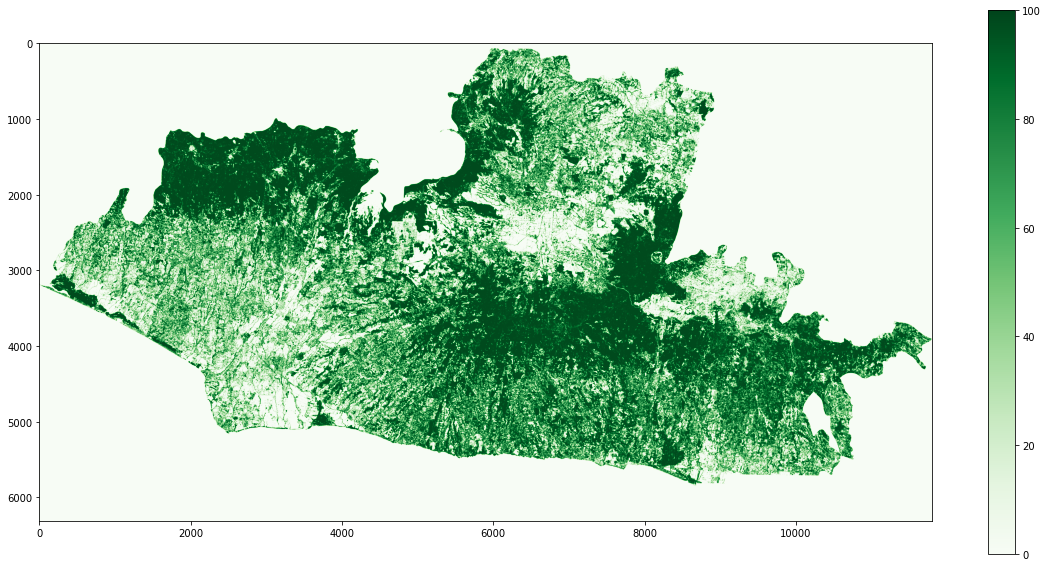

In [20]:
plt.figure(figsize=(20,10))
plt.imshow(tof_data, cmap='Greens', vmin=0, vmax=100)
plt.colorbar()
plt.show()

In [25]:
hansen_data = rs.open("hansen_treecover.tif")
hansen_data = hansen_data.read(1)
print(hansen_data.shape)

(2316, 4331)


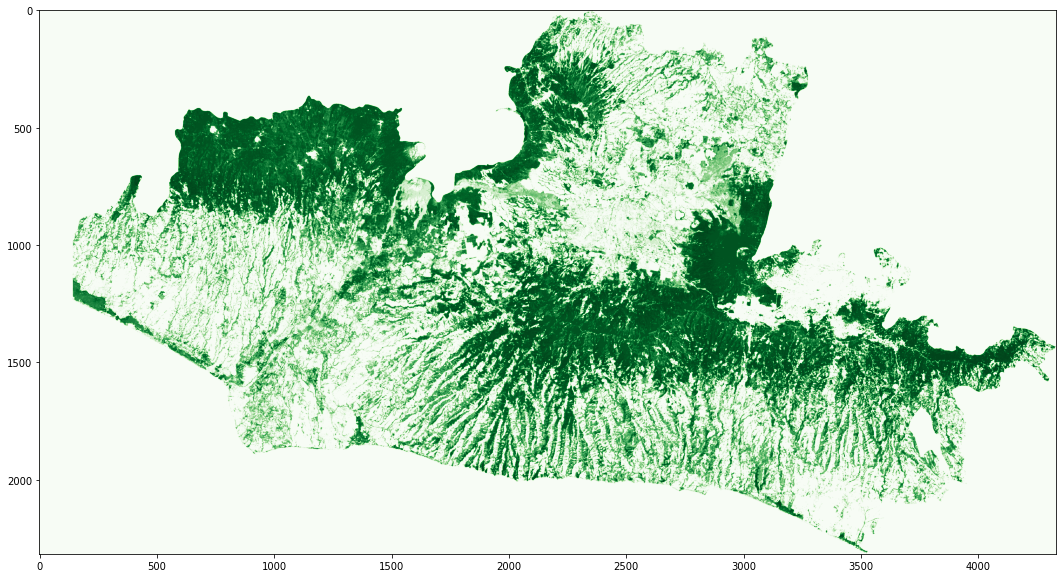

In [26]:
plt.figure(figsize=(20,10))
plt.imshow(hansen_data, cmap='Greens', vmin=0, vmax=100)
plt.show()

In [3]:
# import shapefile
jurisdictions = gpd.read_file('elsalvador_adm2.geojson')

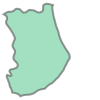

In [24]:
jurisdictions.geometry[0]

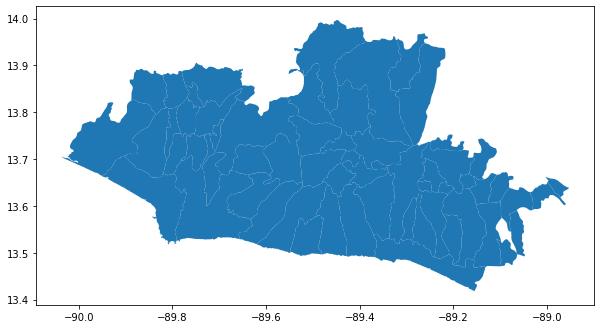

In [70]:
fig, ax = plt.subplots(figsize=(10,10))
jurisdictions.plot(ax=ax);

In [64]:
esa_data = rs.open('ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7.tif')
esa_data = esa_data.read(1)
print(esa_data.shape)

(64800, 129600)


In [46]:
esa_data[60000:,:]

array([[210, 210, 210, ..., 210, 210, 210],
       [210, 210, 210, ..., 210, 210, 210],
       [210, 210, 210, ..., 210, 210, 210],
       ...,
       [220, 220, 220, ..., 220, 220, 220],
       [220, 220, 220, ..., 220, 220, 220],
       [210, 210, 210, ..., 210, 210, 210]], dtype=uint8)

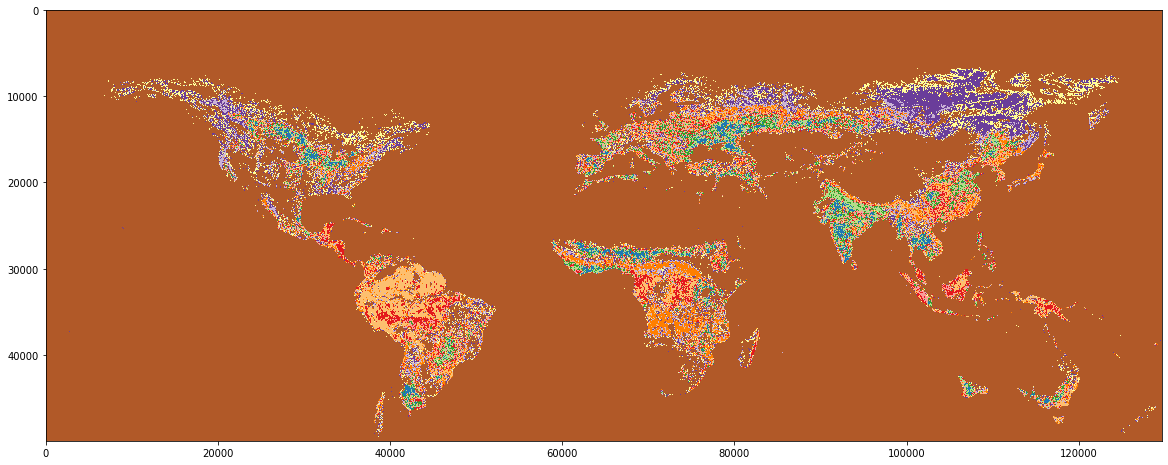

In [47]:
plt.figure(figsize=(20,10))
plt.imshow(esa_data[:50000], cmap='Paired', vmin=0, vmax=100)
plt.show()

## Clip and Resample Rasters
Masking and resampling with Rasterio
- https://gis.stackexchange.com/questions/329434/creating-an-in-memory-rasterio-dataset-from-numpy-array/329439
- https://gis.stackexchange.com/questions/337627/python-mask-raster-array-using-shapefile-or-rasterio

In [4]:
tof_data = rs.open("sentinel_treecover.tif")
hansen_data = rs.open("hansen_treecover.tif")
esa_data = rs.open('ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7.tif')
jurisdictions = gpd.read_file('elsalvador_adm2.geojson')

In [35]:
#Original

def clip_raster(raster, shapefile, data):
    
    '''
    Function takes in a raster file for a country, masks out jurisdictions 
    based on polygons defined in the shapefile and then writes the masked 
    raster to a new file.
    '''
    for geo, juris in zip(shapefile.geometry, shapefile.ADM2_ES):
        
            out_img, out_transform = mask(dataset=raster, shapes=geo, crop=True)
            out_meta = raster.meta
            out_meta.update({'driver': 'GTiff',    
                             'dtype': 'uint8',
                             'height': out_img.shape[1],
                             'width': out_img.shape[2],
                             'transform': out_transform})

            outpath = os.path.join(f'clipped_rasters/{data}', f'{str(juris)}')
            with rs.open(outpath, "w", **out_meta) as dest:
                dest.write(out_img)
           
    return f'{data} rasters clipped and saved.'

In [48]:
# separate function for resample method, bc returns the data in a numpy array
# need to convert results into valid DatabaseReader

def resample_raster(jurisdiction_list, data, scale):

    for juris in jurisdiction_list:
        
        outpath = f'clipped_rasters/{data}/{juris}'
        
        with rs.open(outpath) as raster:

            # resample data to target shape
            resampled = raster.read(out_shape=(raster.count,
                                                int(raster.height * scale),
                                                int(raster.width * scale)),
                                     resampling=Resampling.bilinear)

            # scale image transform
            transform = raster.transform * raster.transform.scale((raster.width / resampled.shape[-1]),
                                                                   (raster.height / resampled.shape[-2]))
            
            # use metadata/profile? from input raster and modify properties
            profile = raster.profile
            profile.update({'driver': 'GTiff',    
                             'dtype': 'uint8',
                             'height': int(raster.height * scale),
                             'width': int(raster.width * scale),
                             'transform': transform})
            
            #print(f'Orig dims for {juris}: {raster.shape}, New dims: {resampled.shape}')
            
            # Open as DatasetWriter
            with rs.open(outpath, 'w', **profile) as dataset:  
                dataset.write(resampled)

            # Reopen as DatasetReader
            with rs.open(outpath) as dataset:  
                yield dataset

# Do I need to create a memfile?
            
#             # Open as DatasetWriter
#             with MemoryFile() as memfile:
#                 with memfile.open(**profile) as dataset: 
#                     dataset.write(resampled)
#                     del resampled
                
#                 # Reopen as DatasetReader
#                 with memfile.open() as dataset:  
#                     yield dataset  # Note yield not return     

In [37]:
clip_raster(hansen_data, jurisdictions, 'hansen')

'hansen rasters clipped and saved.'

In [49]:
resample_raster(['Acajutla', 'Jujutla'], 'hansen', 3)

<generator object resample_raster at 0x7fb393bfe408>

In [50]:
# before resample (650, 798)
# size is the same
jujutla_han = rs.open('clipped_rasters/hansen/Jujutla').read(1)
jujutla_han.shape

(650, 798)

In [38]:
Acajutla_tof = rs.open('clipped_rasters/tof/Acajutla').read(1)
Acajutla_han = rs.open('clipped_rasters/hansen/Acajutla').read(1)
Acajutla_esa = rs.open('clipped_rasters/esa/Acajutla').read(1)

print(f'tof:{Acajutla_tof.shape} hansen:{Acajutla_han.shape} esa:{Acajutla_esa.shape}')

tof:(2054, 1976) hansen:(755, 725) esa:(69, 66)


## Calculate Tree Cover per Jurisdiction

In [27]:
def tree_cover_stats(jurisdiction_list, tof, hansen):
    
    '''
    Takes in a list of jurisdictions and calculates tree cover statistics
    for based on tof and hansen data layers, returns numbers in a dataframe.
    '''

    def calculate_stats(jurisdiction, raster, folder_name): 
        clipped_raster = rs.open(f'clipped_rasters/{folder_name}/{jurisdiction}').read(1)
        
        # transform Hansen data to 10m grid scale
        if folder_name == 'hansen':
            clipped_raster = clipped_raster.repeat(3, axis=0).repeat(3, axis=1)
        else:
            pass
        
        def round_down(num, divisor):
                return num - (num%divisor)
        rows, cols = round_down(clipped_raster.shape[0], 10), round_down(clipped_raster.shape[1], 10)
        rounded = clipped_raster[:rows, :cols]
        reshaped = np.reshape(rounded, (int(rounded.shape[0] / 10), 10, int(rounded.shape[1] / 10), 10))
        mean = round(np.mean(reshaped), 3)      # mean tree cover for the jurisdiction
        mean_tc = np.mean(reshaped, axis=(1,3)) # mean tree cover per hectare
        ha_over10 = np.sum(mean_tc > 10)        # num of hectares with mean tree cover >10%
        
        return mean, ha_over10
    
    tree_cover = pd.DataFrame(columns=['jurisdiction', 'tof_mean_tc', 'tof_total_ha',
                                       'hansen_mean_tc', 'hansen_total_ha'])
    
    for i in jurisdiction_list:
        tof_tc, tof_over10 = calculate_stats(i, tof, 'tof')
        hansen_tc, hansen_over10 = calculate_stats(i, hansen, 'hansen')
        
        tree_cover = tree_cover.append({'jurisdiction': i, 
                                        'tof_mean_tc': tof_tc, 
                                        'tof_total_ha': tof_over10,
                                        'hansen_mean_tc': hansen_tc, 
                                        'hansen_total_ha': hansen_over10}, ignore_index=True)
        
        tree_cover['tof_hans'] = tree_cover['tof_total_ha'] - tree_cover['hansen_total_ha']
    
    return tree_cover

In [28]:
df = tree_cover_stats(list(jurisdictions.ADM2_ES), tof_data, hansen_data)

In [33]:
# calculations by ESA LC

def tc_by_lc(jurisdiction_list, ):
    
    '''
    import and update size of the esa raster
    for every land cover type in the esa raster,
    calculate the mean tree cover for tof and hansen.
    return a df with the jurisdiction name, land cover class
    percent tree cover and ha tree cover
    '''
    for jurisdiction in jurisdiction_list:
        
        # open the clipped esa raster for each jurisdiction
        esa_raster = rs.open(f'clipped_rasters/esa/{jurisdiction}').read(1)
        
        # get a list of land cover classes in that jurisdiction
        lc_classes = np.unique(esa_raster)
        
        # transform ESA data to 10m grid scale (current 300m resolution)
        esa_raster = esa_raster.repeat(30, axis=0).repeat(30, axis=1)
    
        
        def round_down(num, divisor):
                return num - (num%divisor)
        
        rows, cols = round_down(esa_raster.shape[0], 10), round_down(esa_raster.shape[1], 10)
        rounded = esa_raster[:rows, :cols]
        reshaped = np.reshape(rounded, (int(rounded.shape[0] / 10), 10, int(rounded.shape[1] / 10), 10))
        
        for cover in lc_classes:
        # calculate the mean tree cover using np.where(esa_raster == class)
        # possible to clip the esa raster to be the same size as the tof/hansen raster?
        

In [42]:
esa_raster = rs.open(f'clipped_rasters/esa/Jujutla').read(1)
esa_raster.shape

(59, 73)

In [43]:
lc_classes = np.unique(esa_raster)
lc_classes

array([  0,  10,  11,  30,  40,  50,  60, 100, 170, 190, 210], dtype=uint8)

In [44]:
esa_raster = esa_raster.repeat(30, axis=0).repeat(30, axis=1)
esa_raster.shape

(1770, 2190)

In [46]:
def round_down(num, divisor):
    return num - (num%divisor)

rows, cols = round_down(esa_raster.shape[0], 10), round_down(esa_raster.shape[1], 10)

In [47]:
rounded = esa_raster[:rows, :cols]
rounded.shape

(1770, 2190)

In [48]:
reshaped = np.reshape(rounded, (int(rounded.shape[0] / 10), 10, int(rounded.shape[1] / 10), 10))
reshaped.shape

(177, 10, 219, 10)

In [ ]:
for lc in lc_classes:
    mean = round(np.mean(reshaped), 3)      # mean tree cover for the jurisdiction
    mean_tc = np.mean(reshaped, axis=(1,3)) # mean tree cover per hectare
    ha_over10 = np.sum(mean_tc > 10)

In [34]:
tc_by_lc(['Jujutla'])

array([  0,  10,  11,  30,  40,  50,  60, 100, 170, 190, 210], dtype=uint8)

In [22]:
# save to csv
df.to_csv('tree-cover-el-salvador.csv', index=False)

## Visual Comparisons

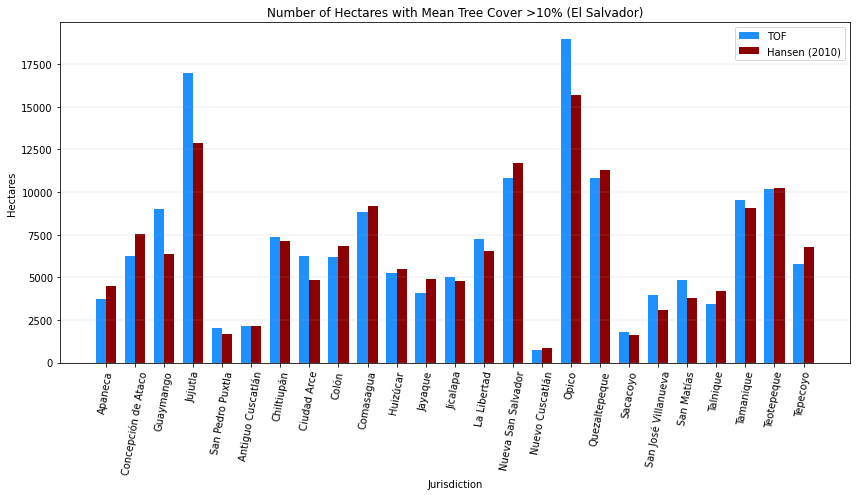

In [28]:
labels = list(df.jurisdiction)[:25]
x = np.arange(len(labels))  
width = 0.35  # the width of the bars

plt.figure(figsize=(12,7))
plt.bar(x - width/2, df.tof_total_ha[:25], width, label='TOF', color='dodgerblue')
plt.bar(x + width/2, df.hansen_total_ha[:25], width, label='Hansen (2010)', color='darkred')

plt.ylabel('Hectares')
plt.xlabel('Jurisdiction')
plt.title('Number of Hectares with Mean Tree Cover >10% (El Salvador)')
plt.xticks(x, labels=labels, rotation=80)
plt.legend()
plt.grid(axis='y', linewidth=.2)

plt.tight_layout();

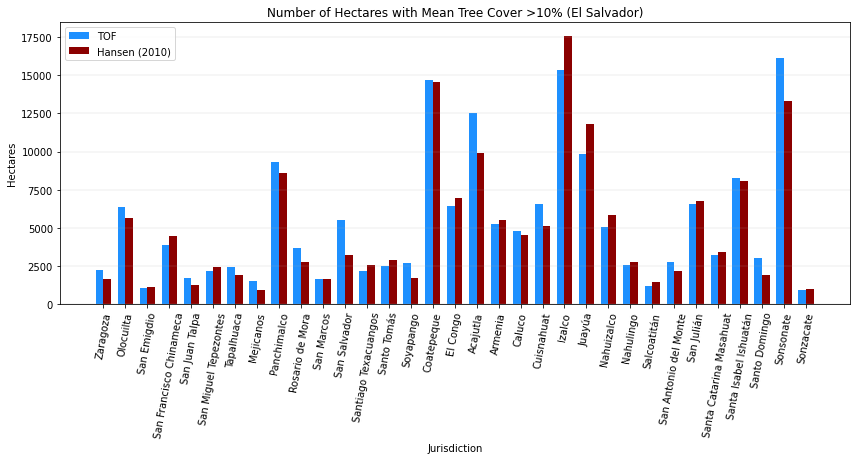

In [36]:
labels = list(df.jurisdiction)[25:]
x = np.arange(len(labels))  
width = 0.35  # the width of the bars

plt.figure(figsize=(12,6.5))
plt.bar(x - width/2, df.tof_total_ha[25:], width, label='TOF', color='dodgerblue')
plt.bar(x + width/2, df.hansen_total_ha[25:], width, label='Hansen (2010)', color='darkred')

plt.ylabel('Hectares')
plt.xlabel('Jurisdiction')
plt.title('Number of Hectares with Mean Tree Cover >10% (El Salvador)')
plt.xticks(x, labels=labels, rotation=80)
plt.legend()
plt.grid(axis='y', linewidth=.2)

plt.tight_layout();

In [38]:
# where does TOF see the biggest difference?
df.sort_values(by='ha_diff', ascending=False)[:5]

,jurisdiction,tof_mean_tc,tof_total_ha,hansen_mean_tc,hansen_total_ha,ha_diff
3,Jujutla,26.606,16974,14.555,12873,4101
16,Opico,23.850,18996,13.947,15663,3333
56,Sonsonate,16.146,16138,8.850,13286,2852
2,Guaymango,27.645,9031,12.511,6376,2655
42,Acajutla,14.289,12509,8.300,9899,2610


In [39]:
# where does Hansen see the biggest difference?
df.sort_values(by='ha_diff', ascending=True)[:5]

,jurisdiction,tof_mean_tc,tof_total_ha,hansen_mean_tc,hansen_total_ha,ha_diff
46,Izalco,29.280,15315,24.869,17575,-2260
47,Juayúa,51.107,9832,47.523,11779,-1947
1,Concepción de Ataco,61.418,6281,58.504,7555,-1274
24,Tepecoyo,53.441,5813,49.233,6774,-961
14,Nueva San Salvador,28.830,10850,23.222,11699,-849


In [53]:
jujutla_tof = rs.open('clipped_rasters/tof/Jujutla').read(1)
jujutla_han = rs.open('clipped_rasters/hansen/Jujutla').read(1)
jujutla_esa = rs.open('clipped_rasters/esa/Jujutla').read(1)

print(f'tof:{jujutla_tof.shape} hansen:{jujutla_han.shape} esa:{jujutla_esa.shape}')

tof:(1769, 2176) hansen:(650, 798) esa:(59, 73)


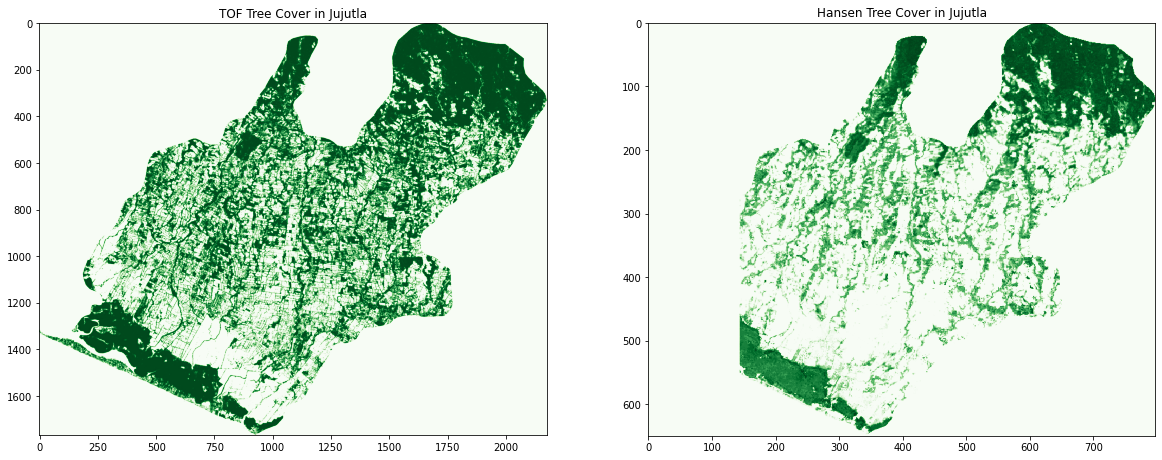

In [54]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(jujutla_tof, cmap='Greens', vmin=0, vmax=100)
plt.title('TOF Tree Cover in Jujutla')

plt.subplot(1,2,2)
plt.imshow(jujutla_han, cmap='Greens', vmin=0, vmax=100)
plt.title('Hansen Tree Cover in Jujutla')


plt.tight_layout;

In [62]:
np.unique(jujutla_esa)

array([  0,  10,  11,  30,  40,  50,  60, 100, 170, 190, 210], dtype=uint8)

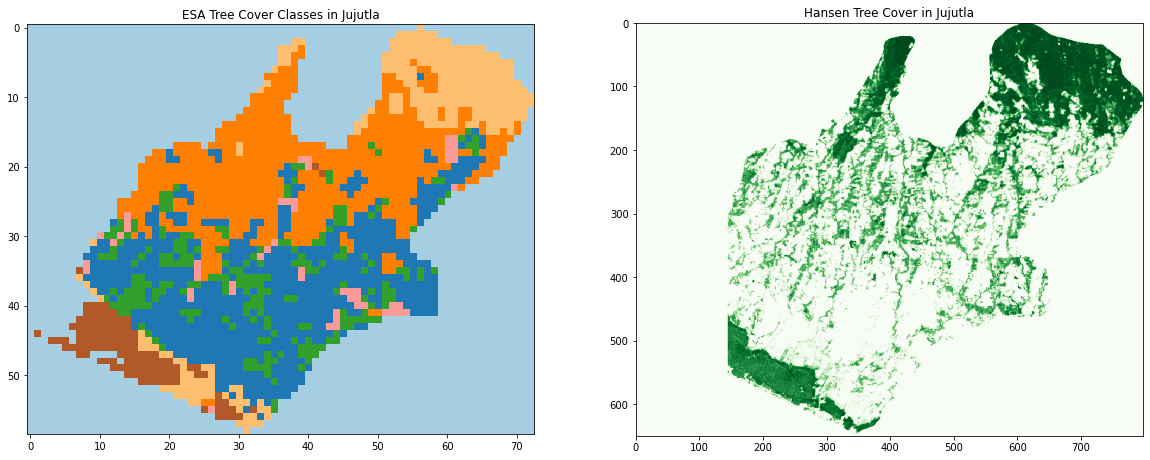

In [38]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(jujutla_esa, cmap='Paired', vmin=0, vmax=100)
plt.title('ESA Tree Cover Classes in Jujutla')

plt.subplot(1,2,2)
plt.imshow(jujutla_han, cmap='Greens', vmin=0, vmax=100)
plt.title('Hansen Tree Cover in Jujutla')


plt.tight_layout;

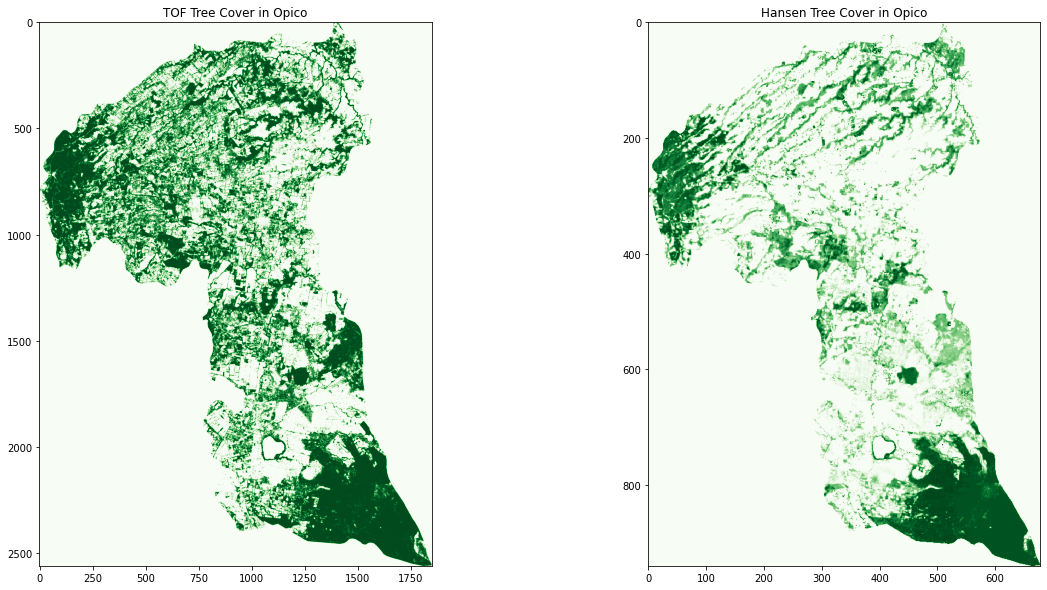

In [103]:
# Visualize tree cover difference for specific jurisdiction

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(opico_tof, cmap='Greens', vmin=0, vmax=100)
plt.title('TOF Tree Cover in Opico')

plt.subplot(1,2,2)
plt.imshow(opico_han, cmap='Greens', vmin=0, vmax=100)
plt.title('Hansen Tree Cover in Opico')


plt.tight_layout;